# Watershed Delineation and Geomorphological Parameter Derivation

This Jupyter Notebook executes the core geospatial analysis steps to delineate the watersheds within the defined study region and compute their relevant geomorphological characteristics. Utilizing the preprocessed Digital Elevation Model (DEM) data (specifically, the sink-filled 1 arc-second tiles organized as VRTs) prepared in the previous notebook, the workflow involves standard hydrological terrain analysis techniques. This typically begins with computing flow direction and flow accumulation grids across the DEM surface. Watershed boundaries are then automatically delineated based on these flow grids, using predefined pour points corresponding to the locations of stream gauge stations. Following the delineation, a comprehensive suite of geomorphological parameters, as identified for this study (e.g., Area, Basin Length, Drainage Density, Relief Ratio, Form Factor, etc.), will be systematically derived for each delineated watershed using the DEM and the delineated boundaries. These quantitative descriptors of basin physiography are essential outputs of this notebook, forming the independent variables dataset that will be used to train the machine learning models for predicting ModClark parameters ($T_c$ and $R$).

In [27]:
# Import libraries
import geopandas as gpd
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
from rasterio.windows import Window
from pysheds.grid import Grid
from pyproj import Transformer
from shapely.geometry import shape, Point
from scipy.ndimage import label
from pysheds.view import Raster, ViewFinder
import json
from plotnine import *
import matplotlib.pyplot as plt


In [2]:
# Set paths
project_root_path = Path.cwd().parent.parent
streamflow_gauge_path = project_root_path / 'data' / 'silver' / 'geo' / 'gpkg' / 'study_area_stream_gauge_stn.gpkg'
vrt = project_root_path /'data' / 'silver' / 'geo' / 'raster' / 'dem1arcsec_filled' / 'dem1arcsec.vrt'

## Pour Points - Stream Gauge Stations

In this section, stream gauge station is loaded, and  its coordinates extracted. To ensure consistent CRS across files, stream gauge stations CRS will be verified.

In [3]:
streamflow_stn = gpd.read_file(streamflow_gauge_path)
print(f'Streamflow Datum:{streamflow_stn.crs.datum}')
streamflow_stn.head()

Streamflow Datum:North American Datum 1983


,STAID,STANAME,ST,HUC,CLASS,FLOW,STAGE,TIME,TIME_UTC,URL,DATUM,COUNT,PERCENTILE,FLOODSTAGE,geometry
0,03165000,"CHESTNUT CREEK AT GALAX, VA",va,05050001,5,59.4,1.56,2025-02-02 12:00:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,79,39.50,7.0,POINT (-80.91924 36.64596)
1,03164000,"NEW RIVER NEAR GALAX, VA",va,05050001,0,0.0,2.18,2025-02-02 12:30:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,94,74.20,9.0,POINT (-80.97897 36.64735)
2,03165500,"NEW RIVER AT IVANHOE, VA",va,05050001,6,3690.0,4.26,2025-02-02 12:50:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,77,81.30,16.0,POINT (-80.95258 36.83485)
3,03161000,"SOUTH FORK NEW RIVER NEAR JEFFERSON, NC",nc,05050001,5,429.0,2.48,2025-02-02 12:30:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,97,53.41,8.0,POINT (-81.40695 36.39334)
4,03208500,"RUSSELL FORK AT HAYSI, VA",va,05070202,7,1490.0,4.60,2025-02-02 12:45:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,97,93.29,16.0,POINT (-82.2957 37.20706)


#### Verify  CRS

The CRS for the original streamflow stations shapefile is **WGS84**. However, by the column `DATUM` is **NAD83**. In notebook [4_streaflow_download.ipynb](notebooks/data_donwload/4_streaflow_download.ipynb), coordinates was downloaded and saved locally from official USGS. Those coordinate will  be used to validate coordinates for the location stations imported above. 

In [4]:
sstn_info_path = project_root_path / 'data/silver/tabular/streamflow/streamflow_stations_info.parquet'
sstn_info = pd.read_parquet(sstn_info_path)
sstn_info.head()    

,site_no,parameter_cd,start_date,end_date,record_count,latitude,longitude,datum
0,03165000,00060,1990-10-01,2025-05-15,12645.0,36.645961,-80.919244,NAD83
1,03164000,00060,1990-10-01,2025-05-15,12645.0,36.647350,-80.978969,NAD83
2,03165500,00060,1996-01-25,2025-05-15,10703.0,36.834845,-80.952581,NAD83
3,03161000,00060,1985-10-01,2025-05-15,14471.0,36.393333,-81.406944,NAD83
4,03208500,00060,1990-10-01,2024-10-01,12419.0,37.207054,-82.295699,NAD83


In [5]:
# Compare location - both file are indicated to be in same datum: NAD83
streamflow_stn['lat'] = streamflow_stn.geometry.y
streamflow_stn['lon'] = streamflow_stn.geometry.x

compare_df = pd.merge(streamflow_stn, sstn_info, how='left', left_on='STAID', right_on='site_no')
compare_df['lat_dif'] = compare_df['lat'] - compare_df['latitude']
compare_df['lon_dif'] = compare_df['lon'] - compare_df['longitude']
compare_df =  compare_df[['site_no','lat_dif', 'lon_dif']]
compare_df.head()

,site_no,lat_dif,lon_dif
0,03165000,0.000001,3.894964e-07
1,03164000,0.000001,3.919413e-07
2,03165500,0.000001,4.977184e-07
3,03161000,0.000003,-4.261743e-06
4,03208500,0.000003,-2.262783e-06


From above, latitude and longitude coordinates are the same for both files.

#### Drop No Data Stations

In [6]:
# Get list of valid data stations id
sstn_historical_data_dir = project_root_path / 'data/bronze/tabular/streamflow'
sstn_list = sstn_historical_data_dir.glob('*.parquet')
sstn_codes = [code.stem.replace('streamflow_','') for code in sstn_list]

valid_stns_bool = streamflow_stn['STAID'].isin(sstn_codes)
valid_stns = streamflow_stn[valid_stns_bool]
valid_stns.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 706 entries, 0 to 1055
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   STAID       706 non-null    object        
 1   STANAME     706 non-null    object        
 2   ST          706 non-null    object        
 3   HUC         705 non-null    object        
 4   CLASS       706 non-null    int32         
 5   FLOW        706 non-null    float64       
 6   STAGE       706 non-null    float64       
 7   TIME        704 non-null    object        
 8   TIME_UTC    706 non-null    datetime64[ms]
 9   URL         706 non-null    object        
 10  DATUM       706 non-null    object        
 11  COUNT       706 non-null    int32         
 12  PERCENTILE  706 non-null    float64       
 13  FLOODSTAGE  706 non-null    float64       
 14  geometry    706 non-null    geometry      
 15  lat         706 non-null    float64       
 16  lon         706 non-nu

In [7]:
# Drop Unecessary columns 
valid_stns = valid_stns[['STAID','STANAME', 'geometry']]

# Merge with station info
valid_stns = valid_stns.merge(right=sstn_info[sstn_info.columns[0:5]], left_on='STAID', right_on='site_no').drop(columns=['STAID'])
valid_stns.head()

,STANAME,geometry,site_no,parameter_cd,start_date,end_date,record_count
0,"CHESTNUT CREEK AT GALAX, VA",POINT (-80.91924 36.64596),03165000,00060,1990-10-01,2025-05-15,12645.0
1,"NEW RIVER NEAR GALAX, VA",POINT (-80.97897 36.64735),03164000,00060,1990-10-01,2025-05-15,12645.0
2,"NEW RIVER AT IVANHOE, VA",POINT (-80.95258 36.83485),03165500,00060,1996-01-25,2025-05-15,10703.0
3,"SOUTH FORK NEW RIVER NEAR JEFFERSON, NC",POINT (-81.40695 36.39334),03161000,00060,1985-10-01,2025-05-15,14471.0
4,"RUSSELL FORK AT HAYSI, VA",POINT (-82.2957 37.20706),03208500,00060,1990-10-01,2024-10-01,12419.0


In [49]:
# Load style configuration for maps
map_style_path = project_root_path / 'config' / 'map_style.json'
with open(map_style_path, 'r') as f:
    map_style = json.load(f).get('map_styles',[])

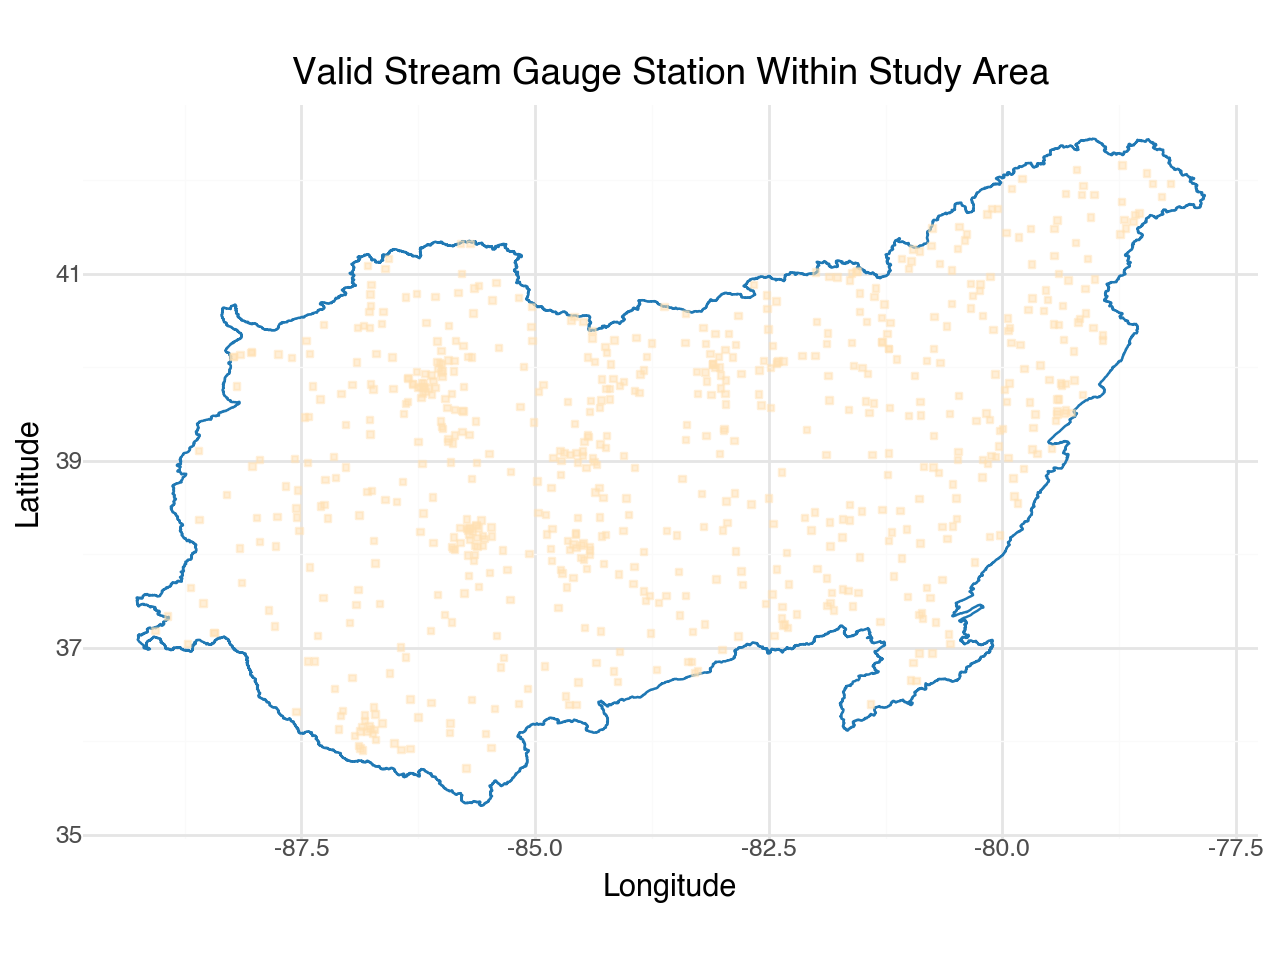

In [50]:
# Map: Location of Stream Gauging Stations
wsb_style = map_style.get('watershed_boundary')

# Load watershed boundaries
watershed_boundary_path = project_root_path / 'data' / 'silver' / 'geo' / 'gpkg' / 'study_area.gpkg'
wsd_boundary = gpd.read_file(watershed_boundary_path)

# Map
stram_gauging_stations_map = (
    ggplot()

    + geom_map(
        mapping=aes(geometry="geometry"),
        data=wsd_boundary,
        inherit_aes=False,
        color=wsb_style.get('color'),
        fill=None,
    )

    + geom_map(
        mapping=aes(geometry= "geometry"),
        data = valid_stns,
        shape = map_style.get('stream_gage').get('shape'),
        fill =  map_style.get('stream_gage').get('fill'),
        color =  map_style.get('stream_gage').get('fill'),
        size =0.8, 
        alpha = 0.5
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="Valid Stream Gauge Station Within Study Area", x="Longitude", y="Latitude")
)
stram_gauging_stations_map.show()

In [14]:
# Salve stations file
valid_stns_path = project_root_path / 'data/gold/geo/gpkg/study_area_stream_gauge_stn.gpkg'
valid_stns_path.parent.mkdir(parents=True, exist_ok=True)

valid_stns.to_file(valid_stns_path)
print(f"Streamflow stations saved to {valid_stns_path}")

Streamflow stations saved to /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/gold/geo/gpkg/study_area_stream_gauge_stn.gpkg


#### Extract Geometry Points

In [15]:
stns_path = project_root_path / 'data/gold/geo/gpkg/study_area_stream_gauge_stn.gpkg'
stns = gpd.read_file(stns_path)
pour_points = pd.DataFrame(
    {'stn_id':stns['site_no'],
     'point': zip(stns.geometry.x, stns.geometry.y)}
)
pour_points.head()

,stn_id,point
0,03165000,"(-80.91924401050363, 36.64596267239885)"
1,03164000,"(-80.97896860805875, 36.64735109440792)"
2,03165500,"(-80.95258020228155, 36.83484669694608)"
3,03161000,"(-81.40694866174323, 36.39333625759056)"
4,03208500,"(-82.2957015627826, 37.20705645973639)"


## Watershed  Delineation and Characteristics Derivation
### Watershed Delineation

DEM is queried from VRT windows. Before passing this data into `PySheds` for stating the delineation process, it will fill in gaps based on average values of all neighbours. Overlapping area are easily resolved by selecting (by default in `raterio` package) the first value. 

In [38]:
from pyproj import Transformer
import rasterio
from pysheds.view import Raster, ViewFinder
import numpy as np
from scipy.ndimage import generic_filter

def get_raster_from_vrt(
    coord: tuple[float, float],
    vrt_path: str,
    buffer_km: float = 50,
    coord_datum: str = "epsg:4269",  # NAD83
    fill_nodata: bool = True
) -> Raster:
    """
    Extracts a DEM subset from a VRT file given a coordinate and asymmetric buffer distance, and optionally fills NoData gaps.

    Parameters
    ----------
        coord (tuple[float, float]): Coordinate (lon, lat) in the specified `coord_datum` CRS.
        vrt_path (str): Path to the .vrt DEM file.
        buffer_km (float): Buffer for top, left, and right. Bottom buffer is fixed at 0.1 km.
        coord_datum (str): EPSG code of the input coordinate system. Default is 'epsg:4269' (NAD83).
        fill_nodata (bool): If True, fills NoData values using neighborhood averaging.

    Returns
    -------
        Raster: PySheds Raster.
    """
    with rasterio.open(vrt_path) as src:
        dem_crs = src.crs

        # Transform coordinates from coord_datum to DEM's CRS
        if coord_datum.lower() != str(dem_crs).lower():
            transformer = Transformer.from_crs(crs_from=coord_datum, crs_to=dem_crs, always_xy=True)
            x, y = transformer.transform(*coord)
        else:
            x, y = coord

        # Determine buffers (asymmetric)
        if dem_crs.is_projected:
            buffer_left = buffer_right = buffer_top = buffer_km * 1000  # meters
            buffer_bottom = 0.1 * 1000  # 0.1 km
        else:
            km_to_deg = 1 / 111  # ~0.009 degrees per km
            buffer_left = buffer_right = buffer_top = buffer_km * km_to_deg
            buffer_bottom = 0.1 * km_to_deg

        # Define asymmetric bounding box
        bounds = [x - buffer_left, y - buffer_bottom, x + buffer_right, y + buffer_top]
        window = src.window(*bounds)

        array = src.read(1, window=window)
        transform = src.window_transform(window)
        shape = array.shape
        crs = src.crs
        nodata = src.nodata

        # Fill NoData values if requested
        if fill_nodata and nodata is not None:
            mask = array == nodata
            array = array.astype('float32')
            array[mask] = np.nan  # Replace NoData with NaN

            def mean_filter(values):
                center = values[len(values) // 2]
                if np.isnan(center):
                    return np.nanmean(values)
                return center

            filled = generic_filter(array, mean_filter, size=3, mode='nearest')
            array = np.where(np.isnan(array), filled, array)
            array = np.where(np.isnan(array), nodata, array)  # Reassign still-NaNs to nodata

        # Build viewfinder and return PySheds Raster
        view_finder = ViewFinder(
            affine=transform,
            shape=shape,
            crs=crs,
            nodata=nodata
        )

        raster = Raster(array, viewfinder=view_finder)
        return raster

In [58]:
# Get DEM example from VRT and coordinate of a pour point example
vrt_path = project_root_path /'data/silver/geo/raster/dem1arcsec_filled/dem1arcsec.vrt'
coord = pour_points.at[0,'point']

example_dem = get_raster_from_vrt(coord, vrt_path)

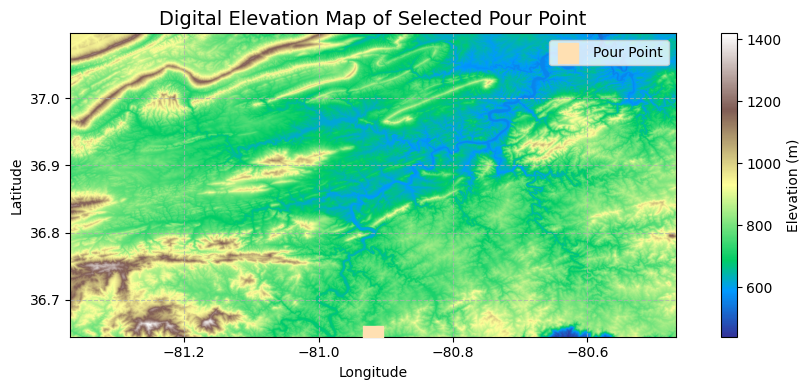

In [64]:
# Print Map of Retrieved DEM from VRT Windows
fig, ax = plt.subplots(figsize=(10,4)) # Slightly larger figure
fig.patch.set_alpha(0)

# Plot the elevation map
dem_im = plt.imshow(example_dem, extent=example_dem.extent, cmap='terrain', zorder=1)
plt.colorbar(dem_im, label='Elevation (m)')

plt.grid(zorder=0, linestyle='--', alpha=0.7)
plt.title('Digital Elevation Map of Selected Pour Point', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add Stream Gauge station
# Reduced size for better visual balance, and adding a label
pour_point_handle = plt.scatter(coord[0], coord[1], color=map_style.get('stream_gage').get('fill'),
                                 marker=map_style.get('stream_gage').get('shape'), s=200, zorder=3, label='Pour Point')


# Add a legend to explain markers
plt.legend(handles=[pour_point_handle], loc='upper right', fontsize=10)


plt.tight_layout()
# plt.savefig('improved_dem_map.png', dpi=300, bbox_inches='tight') # Uncomment to save the map
plt.show()

In [ ]:

def delineate_watershed(pour_point, dem):
    """
    Delineate a watershed and derive its geomorphological characteristics using PySheds.

    """

        
        # Compute flow direction and accumulation
        fdir = grid.flowdir('dem')
        acc = grid.accumulation(fdir)
        
        # Snap pour point to nearest stream cell
        col, row = ~affine * (x, y)
        row, col = int(row), int(col)
        stream_mask = acc > 100  # Threshold may need adjustment
        snapped_row, snapped_col = grid.snap_to_mask(stream_mask, (row, col))
        
        # Delineate watershed
        catchment = grid.catchment(x=snapped_col, y=snapped_row, fdir=fdir, xytype='index')

0